# Ultralearning Project - Time Analysis

### Import required libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import random
style.use('ggplot')

### Pre-Process Dataframe

In [7]:
# Read in our calendar excel file
ul = pd.read_excel("CalendarData_FINAL.xlsx")

# Focus on columns we want to use for analysis
# "Text" represents the title of the event
ul = ul[['Text', 'Weekday', 'Start time', 'End time', 'Description']]
ul = ul[ul['Text'].notna()]
ul['Text'] = ul['Text'].str.lower()

# All events have exactly the same title, which
# makes events spent learning data science easy!
ul = ul[ul.Text.str.contains("data science l")]

# Specify the times as datetime objects
ul['Start time'] = pd.to_datetime(ul['Start time'], format='%Y-%m-%d%H:%M:%S')
ul['End time'] = pd.to_datetime(ul['End time'], format='%Y-%m-%d%H:%M:%S')

# Pick out the times we are interested in
ul['Date'] = ul['Start time'].dt.floor('d')
ul['Year']  = ul['Start time'].dt.year
ul['Month'] = ul['Start time'].dt.month
ul['Day']   = ul['Start time'].dt.day
ul['Hour']   = ul['Start time'].dt.hour


# Calculate the time spent learning in minutes
ul['Duration'] = ul['End time'] - ul['Start time']
ul['Duration'] = ul['Duration'].dt.seconds / 60

ul.head()

,Text,Weekday,Start time,End time,Description,Date,Year,Month,Day,Hour,Duration
69,data science learning,Wednesday,2020-07-29 07:30:00.000000,2020-07-29 08:50:00.000004,\n,2020-07-29,2020,7,29,7,80.000000
74,data science learning,Thursday,2020-07-30 07:20:00.000004,2020-07-30 08:30:00.000003,<ul><li>Completed working with single table sy...,2020-07-30,2020,7,30,7,69.983333
78,data science learning,Friday,2020-07-31 07:14:59.999997,2020-07-31 08:24:59.999996,Learned about joining data together using JOIN...,2020-07-31,2020,7,31,7,69.983333
84,data science learning,Saturday,2020-08-01 15:15:00.000003,2020-08-01 17:30:00.000003,Learned about how on delete operates (deleting...,2020-08-01,2020,8,1,15,135.000000
88,data science learning,Sunday,2020-08-02 12:29:59.999997,2020-08-02 14:41:00.000004,\nGenerated data for my own Zoo database\nCons...,2020-08-02,2020,8,2,12,131.000000


### Group Events by Date

In [8]:
# Group event data by Date and sum their values.
# Some days I break learning into multiple events.
# This ensures that the time spent learning on a 
# given day is the sum of the time spent in all events
# made on that day.
by_day = ul.groupby(['Date']).sum()

# This line of code helps fill in any missing days with 0s.
# Retrieved from: https://stackoverflow.com/questions/31867660/python-pandas-making-date-index-continuous
by_day = by_day.reindex(pd.date_range(min(by_day.index), 
                                      max(by_day.index), 
                                      freq='D')).fillna(0)



### Plot Data Science Over Time

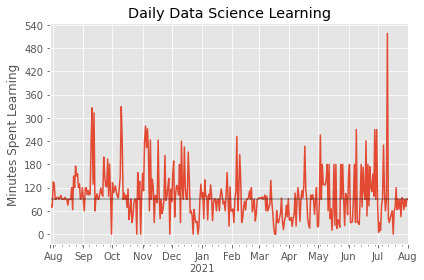

In [9]:
# Plot our duration as a line chart 
by_day['Duration'].plot()

# Add necessary plot and axis titles to the chart
plt.title('Daily Data Science Learning')
plt.ylabel('Minutes Spent Learning')

# Set the yticks to be multiples of 60 to
# easily identify different hours spent learning
plt.yticks(list(range(0, 550, 60)))

# Add the horizontal black line showing the
# daily target learning time
plt.axhline(90, c='black', alpha=0.3)
plt.tight_layout()
plt.savefig(r'DailyDataScienceLearning.png', dpi=300)

## 90 minute goal threshold

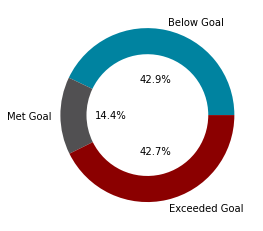

In [10]:
# Less than 90 minutes
below_thresh = len(ul[ul['Duration'] < 90]) / len(ul)
# Exactly 90 minutes
at_thresh = len(ul[ul['Duration'] == 90]) / len(ul)
# Exceeded 90 minutes
above_thresh = len(ul[ul['Duration'] > 90]) / len(ul)

labels = ["Below Goal", "Met Goal", "Exceeded Goal"]
sizes  = [below_thresh, at_thresh, above_thresh]
colors = ["#0083a0", "#515052", "darkred"]

# Figure below accomplished using 
# https://stackoverflow.com/questions/45771474/matplotlib-make-center-circle-transparent
# https://stackoverflow.com/questions/21572870/matplotlib-percent-label-position-in-pie-chart
fig, ax = plt.subplots()

wedges, text, autotext = ax.pie(sizes, colors=colors, labels=labels, 
                                autopct='%1.1f%%', pctdistance=.425)
plt.setp( wedges, width=0.3)

ax.set_aspect("equal")
# The produced png will have a transparent background
plt.savefig("GoalsMet.png", dpi=300, transparent=True)
plt.show()

### Change in Time Spent Learning

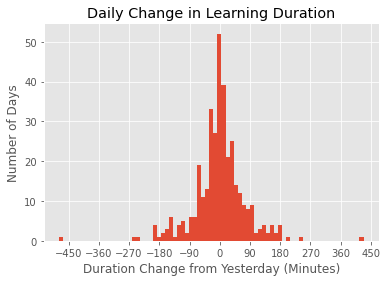

In [11]:
# Calculate duration spent learning by day
by_days = ul.groupby('Date').sum()
by_days = by_days[['Duration']]

# Calculate differences (both absolute and percent) in
# durations spent learning between days
by_days['Change From Yesterday'] = by_days['Duration'].diff()
by_days['Pct Change from Yesterday'] = by_days['Change From Yesterday'] / by_days['Duration'].shift()

# Plot a histogram of the change since yesterday
by_days['Change From Yesterday'].hist(bins=75)

plt.title('Daily Change in Learning Duration')
plt.xlabel('Duration Change from Yesterday (Minutes)')
plt.xticks(list(range(-450, 451, 90)))
plt.ylabel('Number of Days');
plt.savefig(r'MinutesDailyChange.png', dpi=300)

## Learning by Weekday

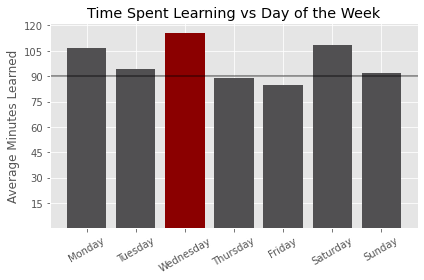

In [12]:
# Make a copy of the dataframe to group by weekday
# and convert the date index into a datetime series object
by_weekday = by_day.reset_index().copy()
by_weekday.rename({'index':'Date'}, axis=1, inplace=True)
by_weekday['Date'] = pd.to_datetime(by_weekday['Date'])

# Group by the mean of the weekday, where Monday is 0 and Friday is 6
weekday_mean = by_weekday.groupby(by_weekday['Date'].dt.weekday).mean()
weekdays = ['Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']
weekday_mean['Weekday'] = weekdays
weekday_mean

# Color most bars grey, but highlight the highest
# bar with a dark red
colors = ["#515052" for i in range(len(weekdays))]
colors[2] = "darkred"

# Plot the average time spent learning by week
plt.bar(weekday_mean['Weekday'], height=weekday_mean['Duration'], color=colors)
plt.xticks(rotation=30)
plt.yticks([15, 30, 45, 60, 75, 90, 105, 120])

# Add chart labels
plt.ylabel('Average Minutes Learned')
plt.title('Time Spent Learning vs Day of the Week')

# Add the 90 minute goal marker
plt.axhline(90, c='black', alpha=0.5)
plt.tight_layout()
plt.savefig(r'Weekdays.png', dpi=300)

## Which starting times are most effective for getting work done?

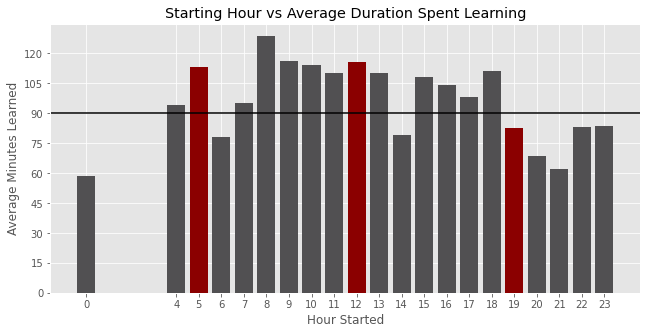

In [13]:
# Group the ultralearning dataframe (ul) by hour and
# count then join this information together to find the
# average time spent learning based on starting hour
learning_by_start_time = ul.groupby(['Hour']).sum()
num_times_started = ul.groupby(['Hour']).count().Weekday
learning_by_start_time = learning_by_start_time.join(num_times_started)
learning_by_start_time.rename({'Weekday': 'Count'}, axis=1, inplace=True)
learning_by_start_time['AvgDuration'] = learning_by_start_time['Duration'] / learning_by_start_time['Count']

# Plot a bar graph of the average duration by hour started
plt.bar(learning_by_start_time.index, height=learning_by_start_time['AvgDuration'], color=colors)

# Color the bars
start_times = sorted(ul['Hour'].unique())
colors = ["#515052" for i in range(len(start_times))]
colors[5] = "darkred"
colors[0] = "#0083a0"   # Cool blue
colors[3] = "#0083a0"   # Cool blue
colors[-3] = "#0083a0"  # Cool blue
colors[-10] = "#0083a0" # Cool blue

# Add additional chart labels and info
plt.xticks(start_times)
plt.yticks(list(range(0, 121, 15)))
plt.title('Starting Hour vs Average Duration Spent Learning')
plt.xlabel('Hour Started')
plt.ylabel('Average Minutes Learned')
plt.axhline(90, c='black')
plt.tight_layout()
plt.gcf().set_size_inches(10, 5)
plt.savefig(r'StartingHours.png', dpi=300)

### Stylized Learning History

In [14]:
by_day

,Year,Month,Day,Hour,Duration
2020-07-29,2020.0,7.0,29.0,7.0,80.000000
2020-07-30,2020.0,7.0,30.0,7.0,69.983333
2020-07-31,2020.0,7.0,31.0,7.0,69.983333
2020-08-01,2020.0,8.0,1.0,15.0,135.000000
2020-08-02,2020.0,8.0,2.0,12.0,131.000000
...,...,...,...,...,...
2021-07-28,2021.0,7.0,28.0,6.0,63.000000
2021-07-29,2021.0,7.0,29.0,4.0,90.000000
2021-07-30,2021.0,7.0,30.0,6.0,71.000000
2021-07-31,2021.0,7.0,31.0,22.0,90.983333


Days of Data Science: 369


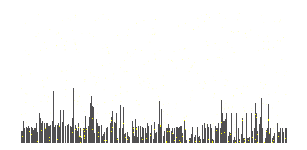

In [24]:
x,y = range(len(by_day)), by_day.Duration

palate = ["#003049","#515052","#ffff00","#fcbf49","#eae2b7"]

# Make our plot
fig, ax, = plt.subplots(ncols=1, figsize=(5.25, 2.5))

# Add a horizontal line
#ax.axhline(y=1.5, color='black', alpha=0.5, linewidth=1,
#           zorder=2)

# Removing those pesky borders
ax.axis('off')

# Add the buildings
ax.bar(x, y, color=palate[1], zorder=1)

# Add lights to the buildings
max_lights_per_building = 200
light_size = 0.025
light_x, light_y = [], []

for pillar_x, pillar_y in zip(x,y):
    # If there is a day that I did
    # DSL
    if pillar_y:
        num_lights = random.randint(0, max_lights_per_building)
        light_y += list(np.random.uniform(light_size, pillar_y, size=num_lights))
        light_x += [pillar_x for i in range(num_lights)]

light_bottom = np.array(light_y) - light_size
ax.bar(light_x, np.array(light_y)-light_bottom, bottom=light_bottom,
       color=palate[2], zorder=2)

# Randomly add stars to the sky
num_stars = len(x) # Number of days of data science
star_x = np.random.uniform(0, len(x), size=num_stars)
star_y = np.random.uniform(low=2, high=max(y)*1.5, size=num_stars)
normal_distribution_sizes = np.random.normal(loc=0.5, scale=0.25, size=len(star_x))
ax.scatter(star_x, star_y,
           s=normal_distribution_sizes,
           c=palate[2], edgecolors='none', marker='*')

# Add a moon to the sky
#ax.scatter(int(len(x)/2), max(y)-1.45,
#          s=100, c='white', zorder=2)
# Add moon border
#ax.scatter(int(len(x)/2), max(y)-1.45,
#          s=130, c=palate[1], zorder=1)

plt.savefig(r'ULTrackerBar_FINAL_Dimmin.png',
            facecolor=palate[0],dpi=300)
            #transparent=True,
            #dpi=300)

print(f"Days of Data Science: {len(x)}")

### Print Stats

In [4]:
# Print out some stats about the time spent learning
print(f"Ultralearning Project Stats (Minutes)\n")
print(f"Total time spent learning:   {round(by_day['Duration'].sum(), 2):,}")
print(f"Max time spent learning:     {round(by_day['Duration'].max(), 2)}")
print(f"Average time spent learning: {round(by_day['Duration'].mean(), 2)}")
print(f"Median time spent learning:  {round(by_day['Duration'].median(), 2)}")

Ultralearning Project Stats (Minutes)



NameError: name 'by_day' is not defined

### Does keeping a description help improve my stats?

#### On average, no

In [17]:
ul[ul['Description'].notna()].mean().Duration

C:\Users\William\anaconda3\envs\snakes\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


101.4047619047619

## How much time spent metalearning?
#### Roughly 5% of the time has been meta-learning. This may need to be increased.

In [18]:
metalearning = ul[ul['Text'].str.contains('meta')]
meta_pct = metalearning['Duration'].sum() / ul['Duration'].sum()
learning_pct = 1 - meta_pct
print(meta_pct, learning_pct)

0.0468582428158944 0.9531417571841057
